In [68]:
#import libraries
import sqlite3
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import math
#connect to the data.db database
conn = sqlite3.connect('data.db')
cursor = conn.cursor()

In [69]:
#importing all the tables in the database
outcomes_df = pd.read_sql_query("select * from Outcomes", conn)
clients_df = pd.read_sql_query("select * from Clients", conn)
campaigns_df = pd.read_sql_query("select * from Campaigns", conn)
accounts_df = pd.read_sql_query("select * from Accounts", conn)

In [70]:
#joining the tables based on foreign keys
query = """
SELECT
c.id AS client_id,
c.age,
c.job,
c.marital,
c.education,
a.balance,
a.in_default,
a.housing,
a.loan,
ca.duration,
ca.campaign,
ca.pdays,
ca.previous,
o.poutcome,
o.y
FROM Clients c
JOIN Accounts a ON c.id = a.client_id
JOIN Campaigns ca ON a.id = ca.account_id
JOIN Outcomes o ON ca.id = o.campaign_id;
"""

# Execute the query and fetch the result into a DataFrame
merged_df = pd.read_sql_query(query, conn)
merged_df

,client_id,age,job,marital,education,balance,in_default,housing,loan,duration,campaign,pdays,previous,poutcome,y
0,4815378,58,management,married,tertiary,2143.0,no,yes,no,261,1,-1,0,unknown,unknown
1,5217541,44,technician,single,secondary,29.0,no,yes,no,151,1,-1,0,unknown,unknown
2,6654642,33,entrepreneur,married,secondary,2.0,no,yes,yes,76,1,-1,0,unknown,unknown
3,1421898,47,blue-collar,married,unknown,1506.0,no,yes,no,92,1,-1,0,unknown,unknown
4,2387933,33,unknown,single,unknown,1.0,no,no,no,198,1,-1,0,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,51,technician,married,tertiary,825.0,no,no,no,977,3,-1,0,unknown,unknown
45207,8051149,71,retired,divorced,primary,1729.0,no,no,no,456,2,-1,0,unknown,unknown
45208,9198356,72,retired,married,secondary,5715.0,no,no,no,1127,5,184,3,success,unknown
45209,3187020,57,blue-collar,married,secondary,668.0,no,no,no,508,4,-1,0,unknown,unknown


In [71]:
#checking for missing values in the table
print(merged_df.isna().sum())  # Check for missing values
merged_df_old = merged_df.copy() #retaining the dataframe before transformation

# Identify duplicate rows
duplicates = merged_df[merged_df.duplicated()]

# Display duplicates
print("Duplicate rows:")
print(duplicates)

client_id     0
age           0
job           0
marital       0
education     0
balance       0
in_default    0
housing       0
loan          0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
y             0
dtype: int64
Duplicate rows:
Empty DataFrame
Columns: [client_id, age, job, marital, education, balance, in_default, housing, loan, duration, campaign, pdays, previous, poutcome, y]
Index: []


In [72]:
#summary statistics for numerical data
summary_stats_numerical = pd.DataFrame(merged_df.describe())

#summary stats for categorical data
categorical_columns = merged_df.select_dtypes(include=['object']).columns
print(categorical_columns)
summary_stats_categorical = pd.DataFrame(merged_df[categorical_columns].describe())
summary_stats_categorical
summary_stats_numerical

Index(['job', 'marital', 'education', 'in_default', 'housing', 'loan',
       'poutcome', 'y'],
      dtype='object')


,client_id,age,balance,duration,campaign,pdays,previous
count,4.521100e+04,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,5.502555e+06,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323
std,2.590577e+06,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441
min,1.000583e+06,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,3.263479e+06,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,5.515908e+06,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,7.735096e+06,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,9.999678e+06,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


<Axes: xlabel='y', ylabel='balance'>

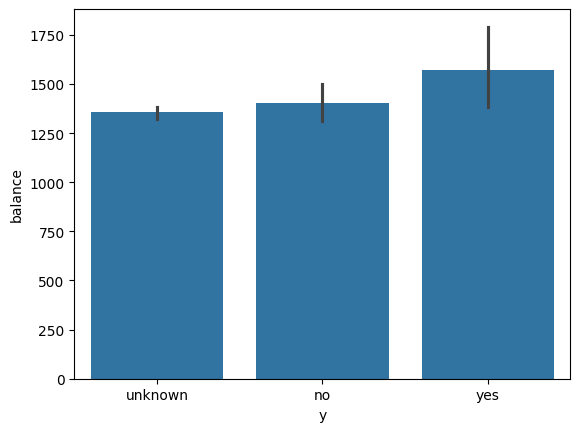

In [73]:
#making catplots for categorical variables
sns.barplot(data=merged_df, x="y", y="balance")

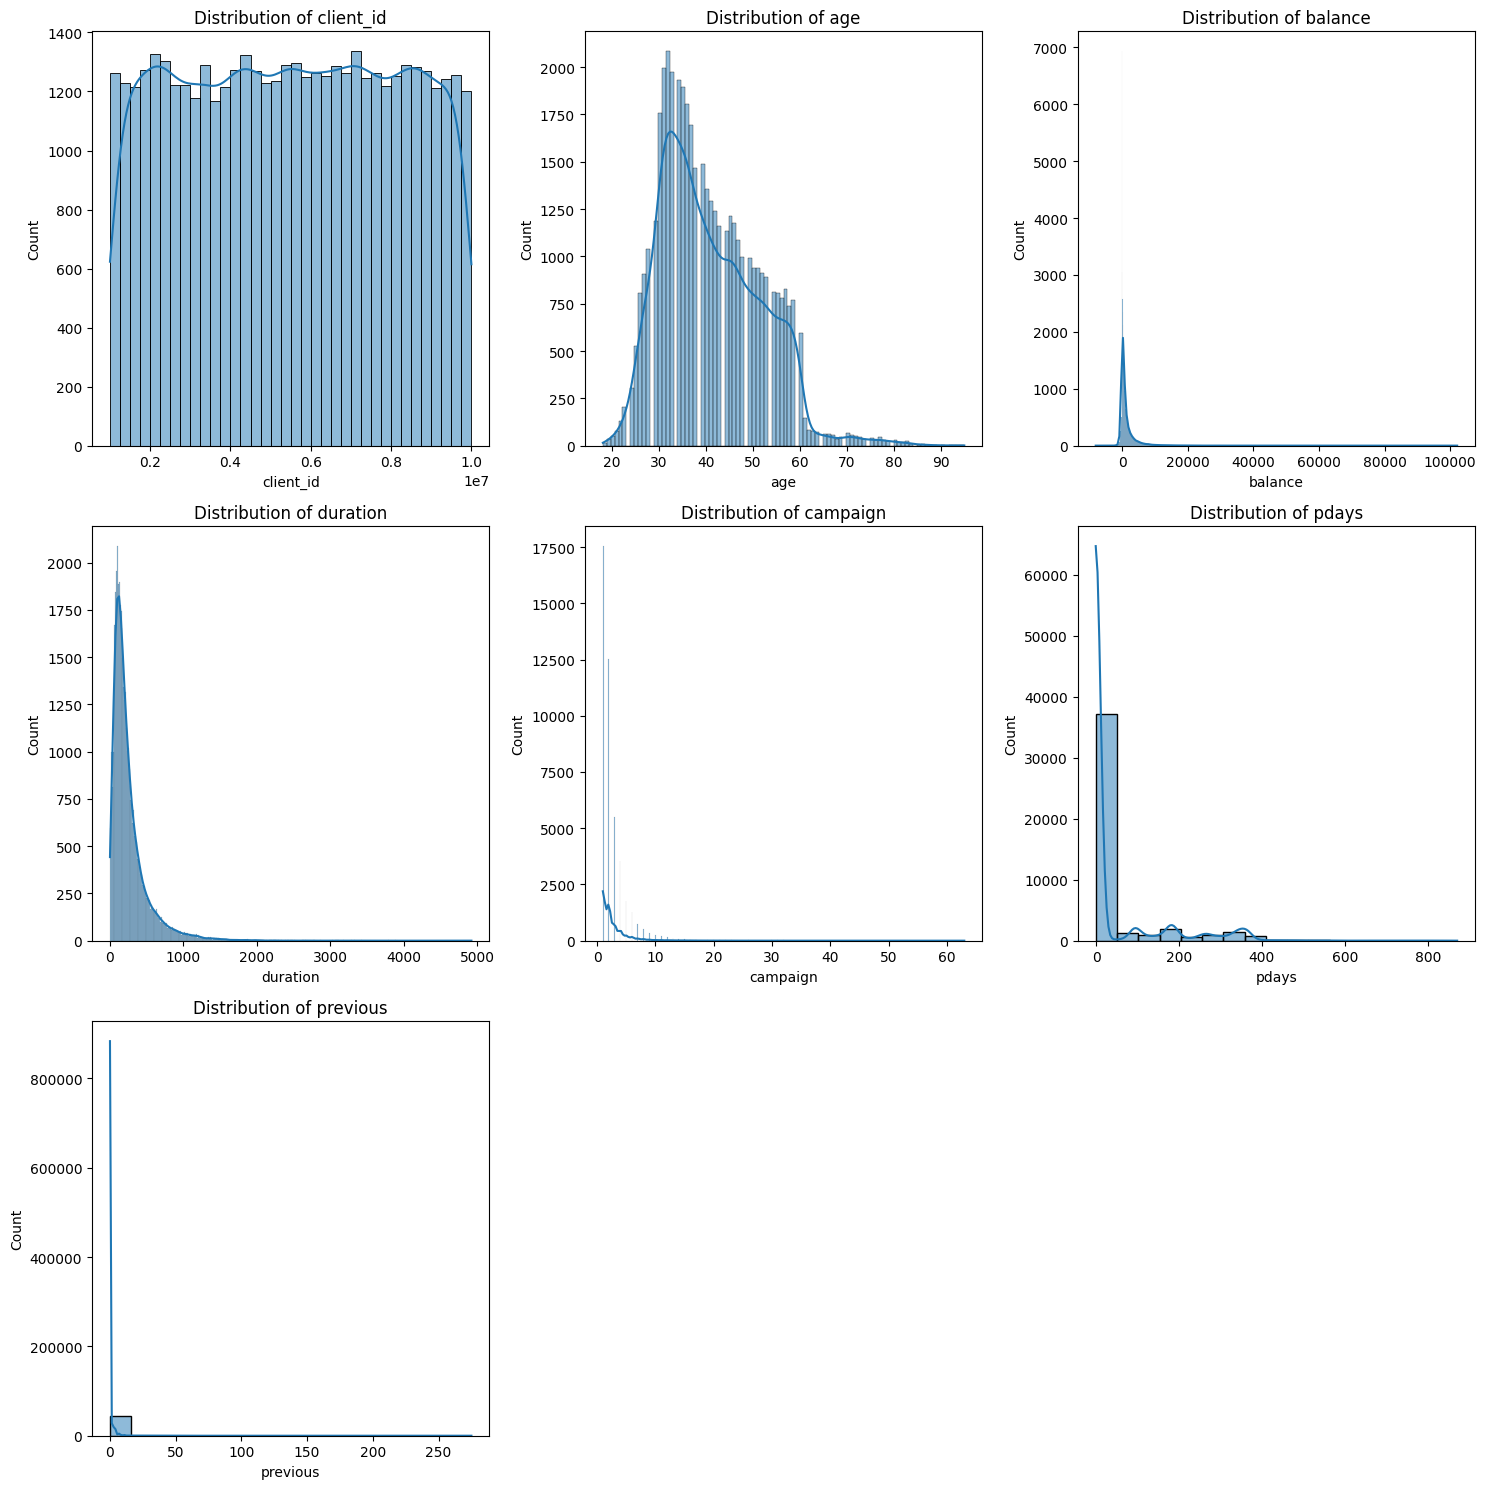

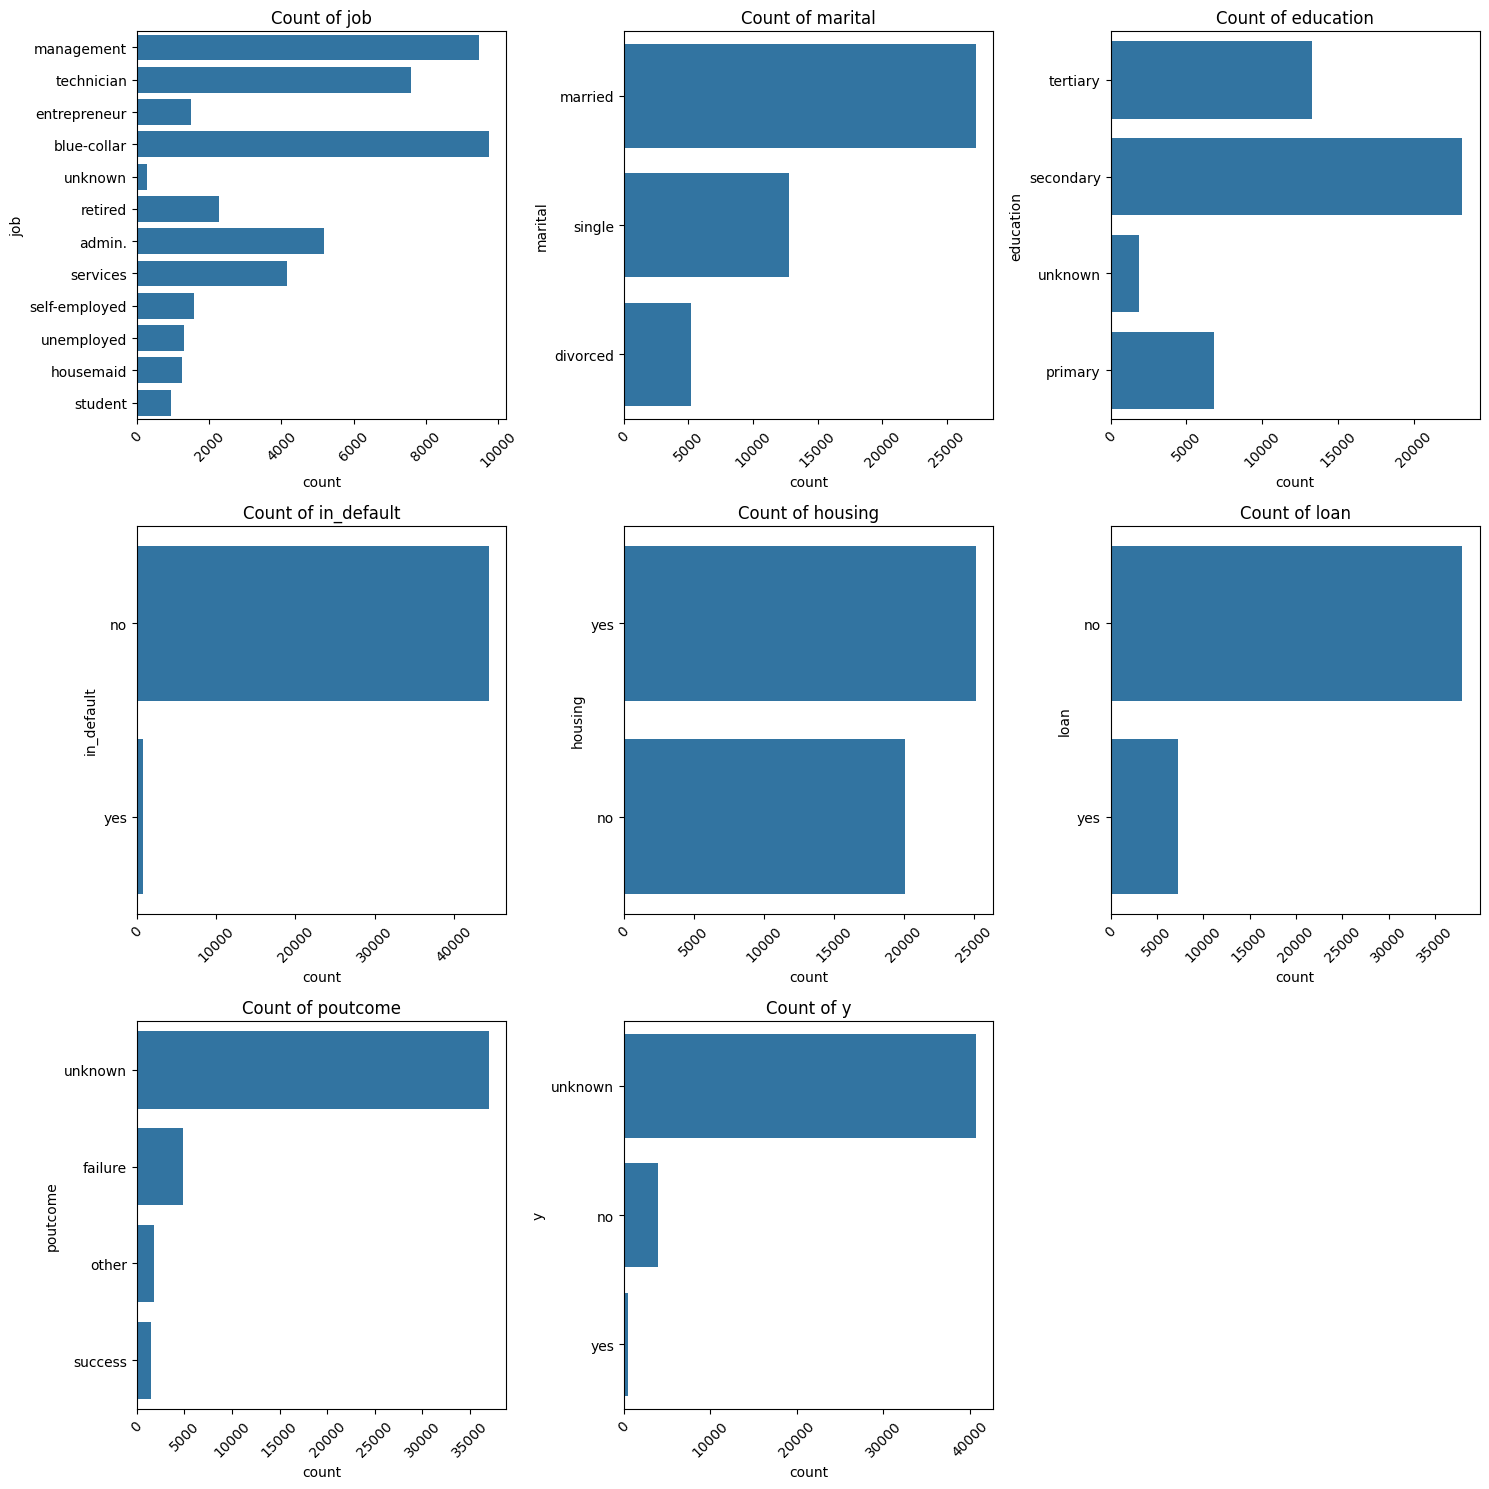

In [74]:
# Numerical columns distribution with subplots
numerical_columns = merged_df.select_dtypes(include=['int64', 'float64']).columns
n_num = len(numerical_columns)
ncols_num = 3  # Number of columns for subplots
nrows_num = math.ceil(n_num / ncols_num)

fig, axes = plt.subplots(nrows=nrows_num, ncols=ncols_num, figsize=(15, 5 * nrows_num))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(merged_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Categorical columns distribution with subplots
categorical_columns = merged_df.select_dtypes(include=['object']).columns
n_cat = len(categorical_columns)
ncols_cat = 3  # Number of columns for subplots
nrows_cat = math.ceil(n_cat / ncols_cat)

fig, axes = plt.subplots(nrows=nrows_cat, ncols=ncols_cat, figsize=(15, 5 * nrows_cat))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(merged_df[col], ax=axes[i])
    axes[i].set_title(f'Count of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [75]:
#picking out rows where they said subscribed to deposit (y=2) and did no (y=0)
condition = (merged_df.y == 'yes') | (merged_df.y =='no')
y_with_outcome = merged_df[condition]
y_with_outcome

,client_id,age,job,marital,education,balance,in_default,housing,loan,duration,campaign,pdays,previous,poutcome,y
7,5561468,42,entrepreneur,divorced,tertiary,2.0,yes,yes,no,380,1,-1,0,unknown,no
9,5203129,43,technician,single,secondary,593.0,no,yes,no,55,1,-1,0,unknown,no
14,6633578,57,services,married,secondary,162.0,no,yes,no,174,1,-1,0,unknown,no
30,9718018,57,technician,married,secondary,839.0,no,no,yes,225,1,-1,0,unknown,no
33,1174906,59,blue-collar,married,secondary,0.0,no,yes,no,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45160,4645105,35,technician,married,secondary,0.0,no,yes,no,524,1,96,5,success,yes
45173,2354794,36,admin.,single,tertiary,980.0,no,no,no,118,4,104,7,failure,no
45191,9424440,75,retired,divorced,tertiary,3810.0,no,yes,no,262,1,183,1,failure,yes
45197,2721327,36,management,single,secondary,1511.0,no,yes,no,270,1,-1,0,unknown,yes


In [76]:
import pandas as pd
from itertools import product
import scipy.stats as ss

def chi_squared_testing(data, cat_var1, cat_var2, target_column, outcome_values):
    """
    Performs Chi-squared testing for all combinations of categorical variables.

    Parameters:
    data (pd.DataFrame): The dataset containing categorical variables.
    cat_var1 (list): List of categorical variables to test against cat_var2.
    cat_var2 (list): List of categorical variables to test against cat_var1.
    target_column (str): Name of the target column (e.g., 'y').
    outcome_values (list): List of target values to filter on (e.g., ['yes', 'no']).

    Returns:
    pd.DataFrame: Crosstab DataFrame with p-values from Chi-squared tests.
    """
    # Filter data based on the target column outcomes
    condition = data[target_column].isin(outcome_values)
    filtered_data = data[condition]

    # Create all possible combinations of variables
    cat_var_prod = list(product(cat_var1, cat_var2, repeat=1))

    # Perform Chi-squared tests
    result = []
    for var1, var2 in cat_var_prod:
        if var1 != var2:  # Avoid testing a variable against itself
            contingency_table = pd.crosstab(filtered_data[var1], filtered_data[var2])
            _, p_value, _, _ = ss.chi2_contingency(contingency_table)
            result.append((var1, var2, p_value))

    # Convert results into a DataFrame
    chi_test_output = pd.DataFrame(result, columns=['var1', 'var2', 'p_value'])

    # Pivot to create a crosstab with p-values
    chi_squared_output = chi_test_output.pivot(index='var1', columns='var2', values='p_value')

    return chi_squared_output


In [77]:
# List of categorical variables
cat_var1 = ['job', 'marital', 'education', 'in_default', 'housing', 'loan', 'poutcome', 'y']
cat_var2 = ['job', 'marital', 'education', 'in_default', 'housing', 'loan', 'poutcome', 'y']

# Filtered outcomes for the target column
outcome_values = ['yes', 'no']

# Perform Chi-squared testing
chi_squared_result = chi_squared_testing(data=y_with_outcome, 
                                         cat_var1=cat_var1, 
                                         cat_var2=cat_var2, 
                                         target_column='y', 
                                         outcome_values=outcome_values)

# Display the result
pd.DataFrame(chi_squared_result)


var2,education,housing,in_default,job,loan,marital,poutcome,y
var1,,,,,,,,
education,NaN,4.992165e-15,0.390467,0.000000e+00,1.175973e-08,1.560114e-27,1.392098e-01,1.625240e-03
housing,4.992165e-15,NaN,0.729390,1.069462e-74,2.305655e-01,1.604635e-02,7.068478e-18,2.714700e-12
in_default,3.904672e-01,7.293900e-01,NaN,5.936374e-01,3.441355e-05,2.083335e-03,1.806831e-02,1.000000e+00
job,0.000000e+00,1.069462e-74,0.593637,NaN,1.988689e-06,1.372525e-65,1.097210e-02,1.901391e-10
loan,1.175973e-08,2.305655e-01,0.000034,1.988689e-06,NaN,4.338737e-03,2.137670e-03,2.914829e-06
marital,1.560114e-27,1.604635e-02,0.002083,1.372525e-65,4.338737e-03,NaN,3.265368e-01,7.373535e-05
poutcome,1.392098e-01,7.068478e-18,0.018068,1.097210e-02,2.137670e-03,3.265368e-01,NaN,1.539883e-83
y,1.625240e-03,2.714700e-12,1.000000,1.901391e-10,2.914829e-06,7.373535e-05,1.539883e-83,NaN


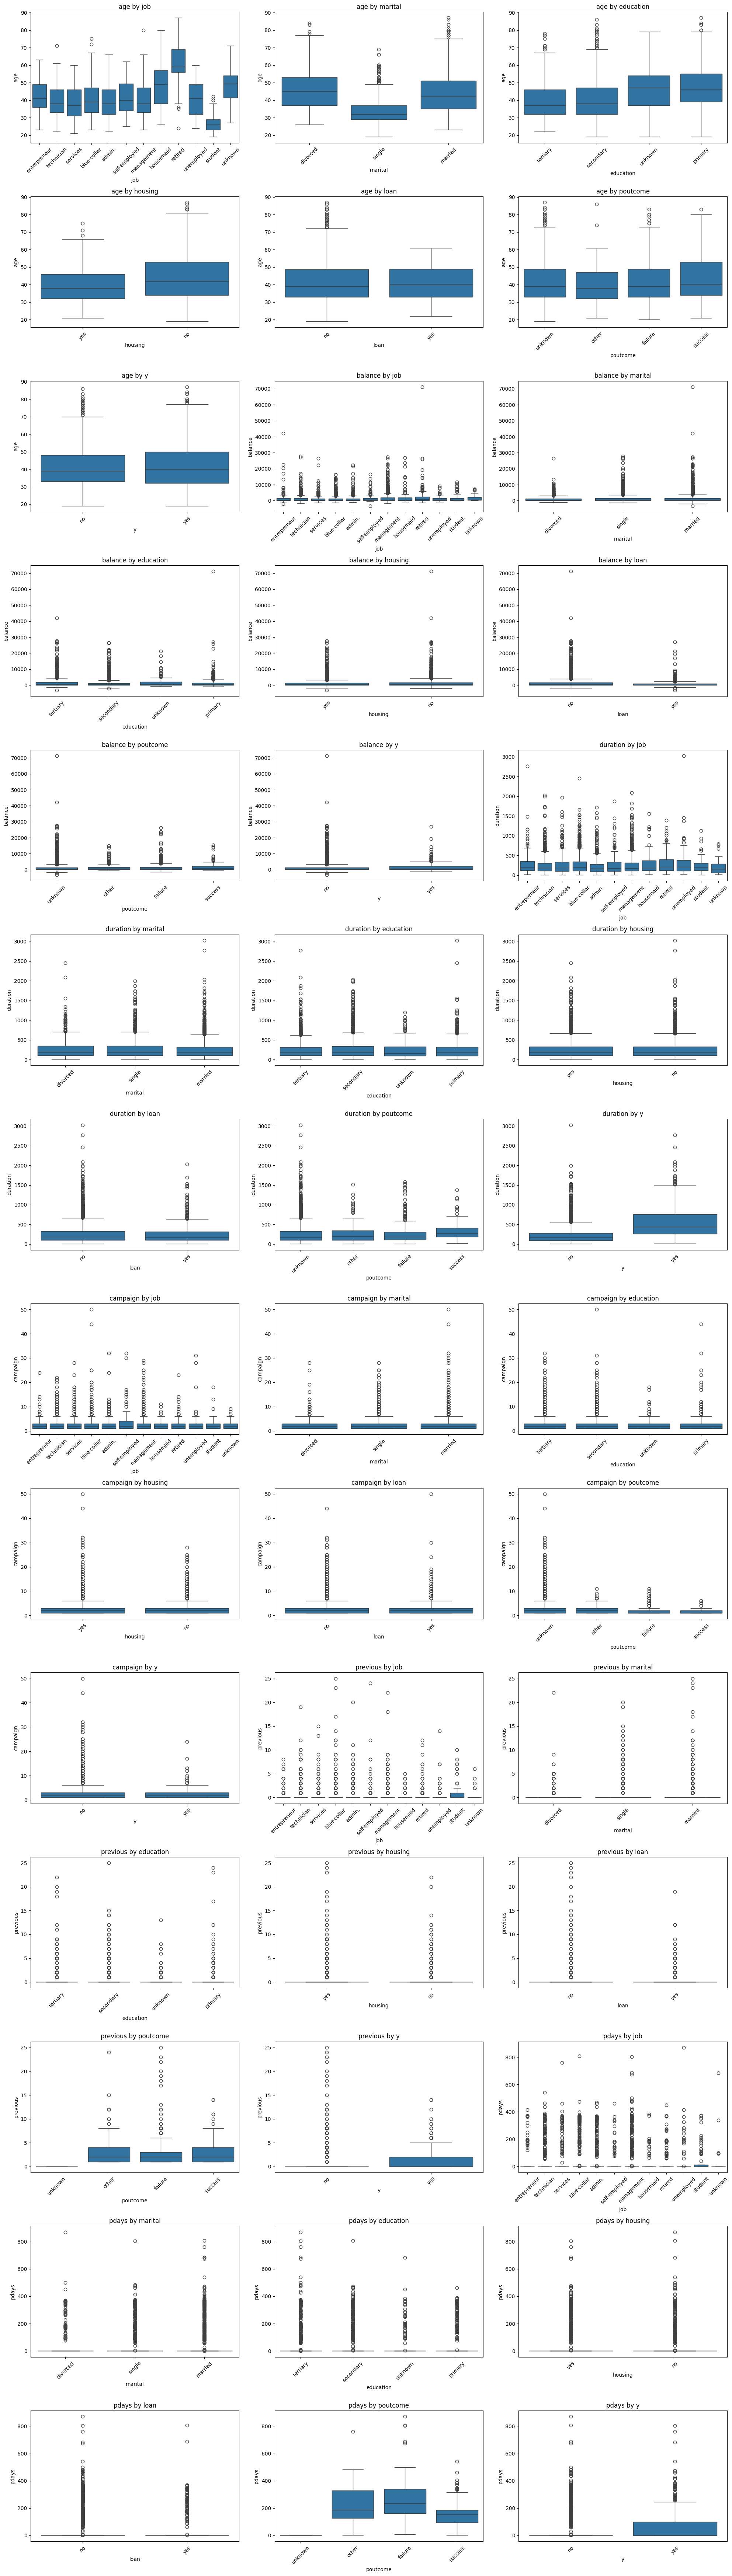

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_boxplots_with_subplots(data, numerical_vars, categorical_vars):
    """
    Plots box plots for all combinations of numerical and categorical variables as subplots.

    Parameters:
    data (pd.DataFrame): The dataset containing the variables.
    numerical_vars (list): List of numerical columns.
    categorical_vars (list): List of categorical columns.
    """
    total_plots = len(numerical_vars) * len(categorical_vars)
    ncols = 3  # Number of columns for subplots
    nrows = math.ceil(total_plots / ncols)  # Number of rows needed

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    plot_idx = 0
    for num_col in numerical_vars:
        for cat_col in categorical_vars:
            if plot_idx < len(axes):  # Ensure no index error
                sns.boxplot(x=cat_col, y=num_col, data=data, ax=axes[plot_idx])
                axes[plot_idx].set_title(f'{num_col} by {cat_col}')
                axes[plot_idx].tick_params(axis='x', rotation=45)
            plot_idx += 1

    # Hide any unused subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage:
# Define numerical and categorical variables
numerical_vars = ['age', 'balance', 'duration', 'campaign', 'previous', 'pdays']
categorical_vars = ['job', 'marital', 'education', 'housing', 'loan', 'poutcome', 'y']

# Call the function with your dataset (replace 'merged_df' with your dataset variable)
plot_boxplots_with_subplots(data=y_with_outcome, numerical_vars=numerical_vars, categorical_vars=categorical_vars)


In [79]:
y_with_outcome.columns

Index(['client_id', 'age', 'job', 'marital', 'education', 'balance',
       'in_default', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [80]:
# Define the conditions for categorizing ages
conditions = [
    y_with_outcome['age'] < 35,
    (y_with_outcome['age'] >= 35) & (y_with_outcome['age'] < 60),
    y_with_outcome['age'] >= 60
]

# Define the corresponding categories
choices = ['young', 'middle', 'old']

# Apply the conditions and create a new column for age categories
y_with_outcome['age_category'] = np.select(conditions, choices, default='unknown')

C:\Users\rukhm\AppData\Local\Temp\ipykernel_25888\622023214.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_with_outcome['age_category'] = np.select(conditions, choices, default='unknown')


In [81]:
y_with_outcome = y_with_outcome.drop(['age'],axis=1)


In [82]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select the columns to be one-hot encoded
columns_to_encode = ['job', 'education','marital','poutcome','age_category']  # Fix: Separate the column names into a list

# Initialize the OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore')  # drop='first' avoids the dummy variable trap

# Apply the encoder to the specified columns
encoded_data = ohe_encoder.fit_transform(y_with_outcome[columns_to_encode])

# Convert the encoded data to a DataFrame
encoded_columns = ohe_encoder.get_feature_names_out(columns_to_encode)

# Convert the sparse matrix to a dense array
encoded_dense = encoded_data.toarray()

# Create a DataFrame from the dense array with appropriate column names
encoded_df = pd.DataFrame(encoded_dense, columns=encoded_columns)
encoded_df


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4517,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4518,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4519,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [83]:
# Reset index for both DataFrames
y_with_outcome = y_with_outcome.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Perform horizontal concatenation
horizontal_concat = pd.concat([y_with_outcome, encoded_df], axis=1)
ohe_df = horizontal_concat

In [84]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

ohe_df['housing'] = label_encoder.fit_transform(ohe_df['housing'])
print('HOUSING converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

ohe_df['loan'] = label_encoder.fit_transform(ohe_df['loan'])
print('LOAN converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

ohe_df['y'] = label_encoder.fit_transform(ohe_df['y'])
print('Y converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

HOUSING converted to number: 
{'no': 0, 'yes': 1}

--------------------------------
LOAN converted to number: 
{'no': 0, 'yes': 1}

--------------------------------
Y converted to number: 
{'no': 0, 'yes': 1}

--------------------------------


In [85]:
ohe_df = ohe_df.drop(['marital','job','education','marital','in_default','poutcome','age_category'], axis=1)

In [86]:
ohe_df.columns

Index(['client_id', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young'],
      dtype='object')

In [87]:
# file_path = 'ohe.csv'
# ohe_df.to_csv(file_path, index=False)

In [88]:
import pandas as pd
from itertools import product
import scipy.stats as ss

def chi_squared_all_combinations(data):
    """
    Performs Chi-squared testing for all combinations of columns in a dataset.

    Parameters:
    data (pd.DataFrame): The one-hot encoded dataset.

    Returns:
    pd.DataFrame: Crosstab DataFrame with p-values from Chi-squared tests.
    """
    columns = data.columns
    combinations = list(product(columns, repeat=2))  # All combinations of columns
    result = []

    for var1, var2 in combinations:
        if var1 != var2:  # Avoid testing a variable against itself
            # Create contingency table
            contingency_table = pd.crosstab(data[var1], data[var2])
            if not contingency_table.empty:
                _, p_value, _, _ = ss.chi2_contingency(contingency_table)
                result.append((var1, var2, p_value))

    # Convert results into a DataFrame
    chi_test_output = pd.DataFrame(result, columns=['var1', 'var2', 'p_value'])

    # Pivot to create a crosstab with p-values
    chi_squared_output = chi_test_output.pivot(index='var1', columns='var2', values='p_value')

    return chi_squared_output


In [89]:
# Run the function
chi_squared_results = chi_squared_all_combinations(ohe_df)


In [90]:
pd.DataFrame(chi_squared_results['y'])

,y
var1,
age_category_middle,3.406608e-05
age_category_old,7.387584e-17
age_category_young,4.342591e-01
balance,1.323321e-03
campaign,2.762976e-01
client_id,4.930075e-01
duration,8.789149e-97
education_primary,7.533433e-02
education_secondary,5.927823e-02


In [91]:
ohe_df

,client_id,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,5561468,2.0,1,0,380,1,-1,0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,5203129,593.0,1,0,55,1,-1,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,6633578,162.0,1,0,174,1,-1,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,9718018,839.0,0,1,225,1,-1,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1174906,0.0,1,0,226,1,-1,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,4645105,0.0,1,0,524,1,96,5,1,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4517,2354794,980.0,0,0,118,4,104,7,0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4518,9424440,3810.0,1,0,262,1,183,1,1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4519,2721327,1511.0,1,0,270,1,-1,0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [92]:
#transforming values into log scale to deal with outliers
ohe_df['duration'] = ohe_df['duration'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('DURATION made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

ohe_df['balance'] = ohe_df['balance'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('BALANCE made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

columns_transform = ['balance','duration','campaign','pdays','previous']
scaler = MinMaxScaler()
ohe_df[columns_transform] = scaler.fit_transform(ohe_df[columns_transform])
ohe_df

DURATION made logaritmic (zero for balance <1): 

--------------------------------
BALANCE made logaritmic (zero for balance <1): 

--------------------------------


,client_id,balance,housing,loan,duration,campaign,pdays,previous,y,job_admin.,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,5561468,0.098327,1,0,0.676500,0.000000,0.000000,0.00,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,5203129,0.571630,1,0,0.377159,0.000000,0.000000,0.00,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,6633578,0.455894,1,0,0.555041,0.000000,0.000000,0.00,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,9718018,0.602644,0,1,0.594967,0.000000,0.000000,0.00,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1174906,0.000000,1,0,0.595656,0.000000,0.000000,0.00,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,4645105,0.000000,1,0,0.726550,0.000000,0.111239,0.20,1,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4517,2354794,0.616532,0,0,0.494834,0.061224,0.120413,0.28,0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4518,9424440,0.737991,1,0,0.618637,0.000000,0.211009,0.04,1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4519,2721327,0.655252,1,0,0.623315,0.000000,0.000000,0.00,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [93]:
# file_path = 'ohe_latest.csv'
# ohe_df.to_csv(file_path, index=False)

In [94]:
ohe_df = ohe_df.drop(['client_id'], axis =1)

In [95]:
#splitting dataset into test and train sets
columns_in_df = ohe_df.columns
X = ohe_df[['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'age_category_middle', 'age_category_old']]
y = ohe_df[['y']]

In [96]:
from sklearn import svm 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split

In [97]:
def cv_svm(xtrain: np.ndarray, ytrain: np.ndarray) -> GridSearchCV:
    """Train and cross-validate a soft-margin SVM classifier with the grid search.

    Define an SVM classifier. Use the grid search and a 5-fold cross-validation
    to find the best value for the hyperparameters 'C' and 'kernel'.

    Args:
        xtrain (np.ndarray): The training data.
        ytrain (np.ndarray): The training labels.

    Returns:
        GridSearchCV: The trained model that was cross-validated with the grid search.
    """
    # 6.1. define dictionary with parameter grids
    #C_values = {'C' : np.logspace(-2, 4, num=6), 'kernel': ['linear', 'rbf', 'poly']} #use only the exponents since it is already to teh base 10

    C_values = {'C': [10**i for i in range(-2, 4, 1)], 'kernel': ['linear', 'rbf', 'poly']}

    # 6.2. initialize svm classifier and perform grid search
    svm_svc =  svm.SVC(class_weight='balanced',probability=True) #initialize the model

    model = GridSearchCV(svm_svc, param_grid= C_values) #gives the best model

    fitted_model = model.fit(xtrain, ytrain) #trains the model and gives the trained model

    return fitted_model

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# Flatten y_train and y_test
y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
y_test = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

# Check shapes after conversion
print(y_train.shape)  # Should now be (3616,)
print(y_test.shape)   # Should now be (905,)

(3616,)
(905,)


In [99]:
model_svm = cv_svm(X_train, y_train) #parameter i.e. c of the model that fit the data the best 

In [100]:
print(model_svm.best_params_)

    # 8. compute and print accuracy of best model on test set
pred_test = model_svm.predict(X_test) #gives predicted labels on test set

accuracy = (sum(y_test == pred_test))/(len(pred_test))*100

print(accuracy)

{'C': 1000, 'kernel': 'rbf'}
81.76795580110497


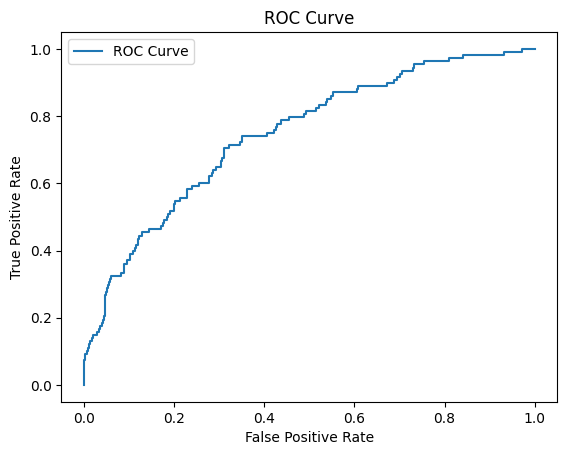

In [101]:
pred_score = model_svm.decision_function(X_test)
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for binary classification
fpr, tpr, _ = roc_curve(y_test, pred_score, pos_label=1)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# logistic regression

In [102]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train logistic regression on the balanced dataset
logreg = LogisticRegression()
log_model = logreg.fit(X_train_balanced, y_train_balanced)


In [103]:
from sklearn.metrics import classification_report, roc_auc_score
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.96      0.79      0.86       797
           1       0.32      0.73      0.45       108

    accuracy                           0.78       905
   macro avg       0.64      0.76      0.65       905
weighted avg       0.88      0.78      0.81       905

ROC-AUC Score: 0.8482039128212279


## random forest

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       797
           1       0.56      0.20      0.30       108

    accuracy                           0.89       905
   macro avg       0.73      0.59      0.62       905
weighted avg       0.86      0.89      0.86       905

Accuracy: 0.89
ROC-AUC Score: 0.86


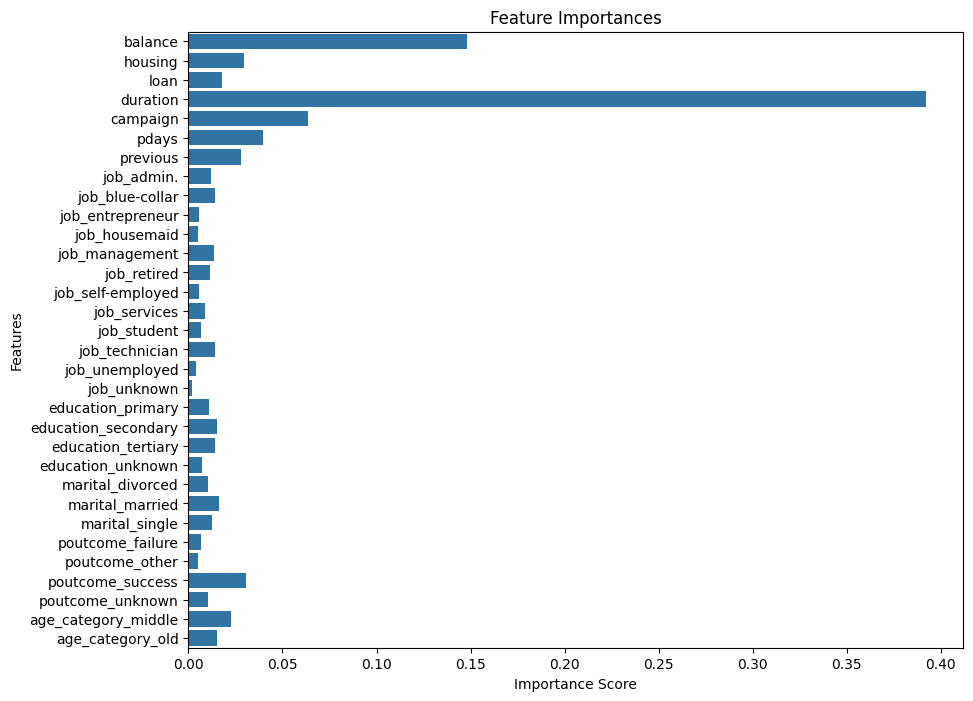

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train.ravel())  # Flatten y_train if necessary

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# ROC-AUC
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Feature Importance Plot
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [105]:
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Combine SMOTE (oversampling) and Edited Nearest Neighbors (undersampling)
smote_enn = SMOTEENN(sampling_strategy='auto',random_state=42)

# Resample the training dataset
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Train Random Forest on the resampled dataset
rf_model_hybrid = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=None)
rf_model_hybrid.fit(X_train_resampled, y_train_resampled)

# Predict on the original test set
y_pred_hybrid = rf_model_hybrid.predict(X_test)

# Evaluate the model
print("Classification Report with SMOTE + Undersampling:")
print(classification_report(y_test, y_pred_hybrid))

# ROC-AUC Score
y_probs_hybrid = rf_model_hybrid.predict_proba(X_test)[:, 1]
roc_auc_hybrid = roc_auc_score(y_test, y_probs_hybrid)
print(f"ROC-AUC Score with SMOTE + Undersampling: {roc_auc_hybrid:.2f}")


Classification Report with SMOTE + Undersampling:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       797
           1       0.36      0.56      0.44       108

    accuracy                           0.83       905
   macro avg       0.65      0.71      0.67       905
weighted avg       0.87      0.83      0.84       905

ROC-AUC Score with SMOTE + Undersampling: 0.83


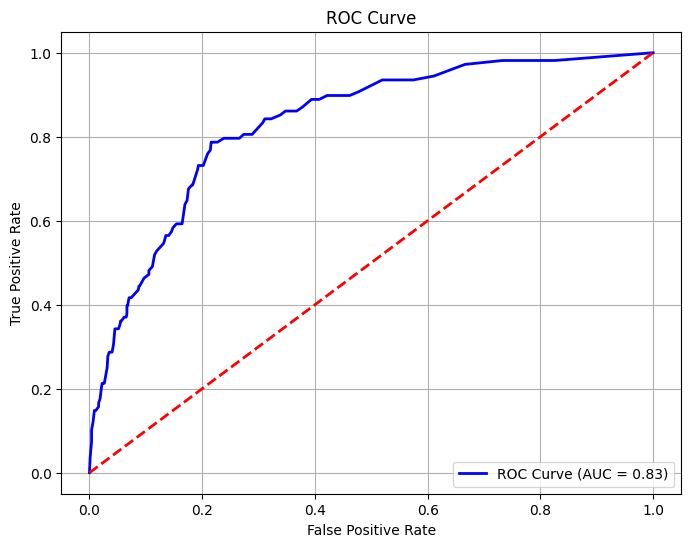

In [106]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score
y_probs_hybrid = rf_model_hybrid.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_probs_hybrid, pos_label=1)  # pos_label should match the positive class
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [107]:
#picking out rows where y is unknown
condition3= merged_df.y =='unknown' #1 - unknown
y_unknown =merged_df[condition3]
y_unknown

,client_id,age,job,marital,education,balance,in_default,housing,loan,duration,campaign,pdays,previous,poutcome,y
0,4815378,58,management,married,tertiary,2143.0,no,yes,no,261,1,-1,0,unknown,unknown
1,5217541,44,technician,single,secondary,29.0,no,yes,no,151,1,-1,0,unknown,unknown
2,6654642,33,entrepreneur,married,secondary,2.0,no,yes,yes,76,1,-1,0,unknown,unknown
3,1421898,47,blue-collar,married,unknown,1506.0,no,yes,no,92,1,-1,0,unknown,unknown
4,2387933,33,unknown,single,unknown,1.0,no,no,no,198,1,-1,0,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,51,technician,married,tertiary,825.0,no,no,no,977,3,-1,0,unknown,unknown
45207,8051149,71,retired,divorced,primary,1729.0,no,no,no,456,2,-1,0,unknown,unknown
45208,9198356,72,retired,married,secondary,5715.0,no,no,no,1127,5,184,3,success,unknown
45209,3187020,57,blue-collar,married,secondary,668.0,no,no,no,508,4,-1,0,unknown,unknown


In [108]:

    # Define the conditions for categorizing ages
conditions = [
    y_unknown['age'] < 35,
    (y_unknown['age'] >= 35) & (y_unknown['age'] < 60),
    y_unknown['age'] >= 60
]

# Define the corresponding categories
choices = ['young', 'middle', 'old']

# Apply the conditions and create a new column for age categories
y_unknown['age_category'] = np.select(conditions, choices, default='unknown')

y_unknown = y_unknown.drop(['age','y'],axis=1)

C:\Users\rukhm\AppData\Local\Temp\ipykernel_25888\3247005881.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_unknown['age_category'] = np.select(conditions, choices, default='unknown')


In [109]:
y_unknown

,client_id,job,marital,education,balance,in_default,housing,loan,duration,campaign,pdays,previous,poutcome,age_category
0,4815378,management,married,tertiary,2143.0,no,yes,no,261,1,-1,0,unknown,middle
1,5217541,technician,single,secondary,29.0,no,yes,no,151,1,-1,0,unknown,middle
2,6654642,entrepreneur,married,secondary,2.0,no,yes,yes,76,1,-1,0,unknown,young
3,1421898,blue-collar,married,unknown,1506.0,no,yes,no,92,1,-1,0,unknown,middle
4,2387933,unknown,single,unknown,1.0,no,no,no,198,1,-1,0,unknown,young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,6145087,technician,married,tertiary,825.0,no,no,no,977,3,-1,0,unknown,middle
45207,8051149,retired,divorced,primary,1729.0,no,no,no,456,2,-1,0,unknown,old
45208,9198356,retired,married,secondary,5715.0,no,no,no,1127,5,184,3,success,old
45209,3187020,blue-collar,married,secondary,668.0,no,no,no,508,4,-1,0,unknown,middle


In [110]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select the columns to be one-hot encoded
columns_to_encode = ['job', 'education','marital','poutcome','age_category']  # Fix: Separate the column names into a list

# Initialize the OneHotEncoder
ohe_encoder = OneHotEncoder(handle_unknown='ignore')  # drop='first' avoids the dummy variable trap

# Apply the encoder to the specified columns
encoded_data = ohe_encoder.fit_transform(y_unknown[columns_to_encode])

# Convert the encoded data to a DataFrame
encoded_columns = ohe_encoder.get_feature_names_out(columns_to_encode)

# Convert the sparse matrix to a dense array
encoded_dense = encoded_data.toarray()

# Create a DataFrame from the dense array with appropriate column names
encoded_df_unknown = pd.DataFrame(encoded_dense, columns=encoded_columns)
encoded_df_unknown

# Reset index for both DataFrames
y_unknown = y_unknown.reset_index(drop=True)
encoded_df_unknown = encoded_df_unknown.reset_index(drop=True)

# Perform horizontal concatenation
horizontal_concat = pd.concat([y_unknown, encoded_df_unknown], axis=1)
encoded_df_unknown = horizontal_concat
encoded_df_unknown



,client_id,job,marital,education,balance,in_default,housing,loan,duration,campaign,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,4815378,management,married,tertiary,2143.0,no,yes,no,261,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,5217541,technician,single,secondary,29.0,no,yes,no,151,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,6654642,entrepreneur,married,secondary,2.0,no,yes,yes,76,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1421898,blue-collar,married,unknown,1506.0,no,yes,no,92,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2387933,unknown,single,unknown,1.0,no,no,no,198,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40685,6145087,technician,married,tertiary,825.0,no,no,no,977,3,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
40686,8051149,retired,divorced,primary,1729.0,no,no,no,456,2,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
40687,9198356,retired,married,secondary,5715.0,no,no,no,1127,5,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
40688,3187020,blue-collar,married,secondary,668.0,no,no,no,508,4,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [111]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_df_unknown['housing'] = label_encoder.fit_transform(encoded_df_unknown['housing'])
print('HOUSING converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

encoded_df_unknown['loan'] = label_encoder.fit_transform(encoded_df_unknown['loan'])
print('LOAN converted to number: ')
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)
print()
print('--------------------------------')

encoded_df_unknown = encoded_df_unknown.drop(['marital','job','education','marital','in_default','poutcome','age_category'], axis=1)

HOUSING converted to number: 
{'no': 0, 'yes': 1}

--------------------------------
LOAN converted to number: 
{'no': 0, 'yes': 1}

--------------------------------


In [112]:
encoded_df_unknown.columns

Index(['client_id', 'balance', 'housing', 'loan', 'duration', 'campaign',
       'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_category_middle', 'age_category_old',
       'age_category_young'],
      dtype='object')

In [113]:

#transforming values into log scale to deal with outliers
encoded_df_unknown['duration'] = encoded_df_unknown['duration'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('DURATION made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

encoded_df_unknown['balance'] = encoded_df_unknown['balance'].apply(
    lambda x: 0 if x <=0 else
              np.log(1+x)  )
print('BALANCE made logaritmic (zero for balance <1): ')
print()
print('--------------------------------')

columns_transform = ['balance','duration','campaign','pdays','previous']
scaler = MinMaxScaler()
encoded_df_unknown[columns_transform] = scaler.fit_transform(encoded_df_unknown[columns_transform])
encoded_df_unknown

encoded_df_unknown

DURATION made logaritmic (zero for balance <1): 

--------------------------------
BALANCE made logaritmic (zero for balance <1): 

--------------------------------


,client_id,balance,housing,loan,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age_category_middle,age_category_old,age_category_young
0,4815378,0.665029,1,0,0.655033,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,5217541,0.294885,1,0,0.590985,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,6654642,0.095250,1,1,0.510984,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1421898,0.634462,1,0,0.533193,0.000000,0.000000,0.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2387933,0.060096,0,0,0.622679,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40685,6145087,0.582331,0,0,0.809978,0.032258,0.000000,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
40686,8051149,0.646427,0,0,0.720478,0.016129,0.000000,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
40687,9198356,0.750047,0,0,0.826764,0.064516,0.216374,0.010909,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
40688,3187020,0.564054,0,0,0.733155,0.048387,0.000000,0.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [114]:

y_predict_log=log_model.predict(encoded_df_unknown)
y_predict_rf=rf_model.predict(encoded_df_unknown)
y_predict_rf_hybrid = rf_model_hybrid.predict(encoded_df_unknown)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age_category_young
- client_id
